<a href="https://colab.research.google.com/github/roni762583/ReinforcementLearning/blob/main/RL2example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

From:
https://github.com/Rachnog/Reinforcement-Learning-in-Finance/blob/main/introduction/Intro_to_RL_for_Trading_harmonic_functions.ipynb

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import tensorflow as tf
import tensorflow.keras as tfk

import collections

In [2]:
# Environment
class Environment:
    '''
        Simple environment
    '''
    def __init__(self, length = 100, normalize = True, noise = True, data = []):
        self.length = length

        if len(data) == 0:
            # self.data = -pd.DataFrame(np.arange(self.length))
            self.data = pd.DataFrame(np.sin(np.arange(length)/30.0))
        else:
            self.data = data

        if noise:
            self.data += pd.DataFrame(np.random.normal(0, 0.1, size=(length, )))

        if normalize:
            self.data = (self.data - self.data.min()) / (self.data.max() - self.data.min())

    def get_state(self, time, lookback, diff = True):
        window = self.data.iloc[time-lookback:time]
        if diff: window = window.diff().fillna(0.0)
        return window

    def get_reward(self, action, action_time, reward_time, coef = 100):
        # 0 => long; 1 => hold, 2 => short
        if action == 0:
            action = 1
        elif action == 1:
            action = 0
        else:
            action = -1
        price_now = self.data.iloc[action_time]
        price_reward = self.data.iloc[reward_time]
        price_diff = (price_reward - price_now) / price_now
        reward = np.sign(price_diff) * action * coef

        return reward.values.tolist()[0]

In [3]:
lin_env = Environment(noise = True)

In [4]:
lin_env.get_state(10, 5, True) # basically a slice of data

,0
5,0.000000
6,0.212174
7,-0.223523
8,0.310116
9,-0.134915


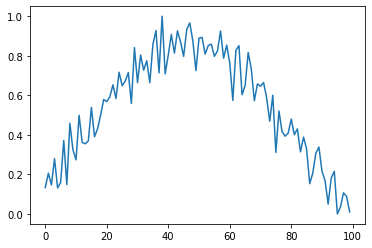

In [5]:
plt.figure()
plt.plot(lin_env.data)
plt.show()

In [6]:
lin_env.get_reward(0, 50, 51)


100.0

In [7]:
# Agent
# import collections # moved to top
class BuyHoldSellAgent:
    '''
        A simple agent
    '''
    def __init__(self, state_shape = 10, action_shape = 3, experience_size = 100):
        self.state_shape = state_shape
        self.action_shape = action_shape
        self.experience_size = experience_size
        self.model = self.init_model()
        self.experience = collections.deque(maxlen=self.experience_size)

    def init_model(self):
        inputs = tfk.Input(shape=(self.state_shape,))
        x = tfk.layers.Dense(10, activation='relu')(inputs)
        outputs = tfk.layers.Dense(self.action_shape, activation='linear')(x)
        model = tfk.Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer=tfk.optimizers.Adam(0.1), loss='mse', metrics='mse')
        return model

    def save_experience(self, state_i, q_value_i, action_i, reward_i, state_i_1):
        self.experience.append({
            'state_i': state_i,
            'q_value_i': q_value_i,
            'action_i': action_i,
            'reward_i': reward_i,
            'state_i_1': state_i_1
        })

    def replay_experience(self, alpha, gamma, sample_size):
        X, Y = [], []
        indices_sampled = np.random.choice(len(self.experience), sample_size, replace=False)
        for i, e in enumerate(self.experience):
            if i in indices_sampled:
                state_i, action_i, reward_i, q_value_i = e['state_i'], e['action_i'], e['reward_i'], e['q_value_i']
                state_i_1 = e['state_i_1']
                q_value_i_1 = self.model.predict(np.expand_dims(state_i_1, 0))[0]
                y_i = np.zeros(self.action_shape)
                y_i[:] = q_value_i[:]
                y_i[action_i] = (1 - alpha) * y_i[action_i] + alpha * (reward_i + gamma * max(q_value_i_1))
                X.append(state_i)
                Y.append(y_i)
        X, Y = np.array(X), np.array(Y)
        self.model.fit(X, Y, epochs=1, batch_size=sample_size, verbose=0)

    def get_value_action_value(self, state):
        pred = self.model.predict(np.expand_dims(state, 0))
        return pred.flatten()


In [8]:
agent = BuyHoldSellAgent()

In [9]:
agent.get_value_action_value(
    pd.DataFrame(np.array(range(10)))
)

array([5.7688823, 4.719177 , 3.1831393], dtype=float32)

In [10]:
# Training
epochs = 5
gamma = 0.9
epsilon = 0.95
alpha = 0.9

DATASET_LENGTH = 250
WINDOW_SHAPE = 5
REWARD_TIME = 1
ACTIONS_SHAPE = 3
SAMPLE_SIZE = 16

In [11]:
environment = Environment(DATASET_LENGTH, True, False)
agent = BuyHoldSellAgent(WINDOW_SHAPE, ACTIONS_SHAPE)

In [12]:
for i in range(epochs):

    learning_progress = []
    for j in range(WINDOW_SHAPE, DATASET_LENGTH - REWARD_TIME, REWARD_TIME): 

        # 1. getting current state
        state_j = environment.get_state(j, WINDOW_SHAPE)
        q_value_j = agent.get_value_action_value(state_j)

        # 2. acting in this state
        if (np.random.random() < epsilon):
            action = np.random.randint(0, ACTIONS_SHAPE)
        else:
            action = (np.argmax(q_value_j))    

        # 3. getting reward from this action
        reward_value_j = environment.get_reward(action, j, j+REWARD_TIME)
        learning_progress.append(reward_value_j)

        # 4. getting next state and value there
        state_j_1 = environment.get_state(j+1, WINDOW_SHAPE)

        # 5. save this experience
        agent.save_experience(state_j, q_value_j, action, reward_value_j, state_j_1)

        if j > SAMPLE_SIZE * 2:
            # 6. train on samples from experience
            agent.replay_experience(alpha, gamma, SAMPLE_SIZE)

    if epsilon > 0.1:
        epsilon -= (1.0/epochs)

    print('Epoch', i, '...', np.mean(learning_progress))
    learning_progress = []

Epoch 0 ... -8.60655737704918
Epoch 1 ... 11.885245901639344
Epoch 2 ... 43.442622950819676
Epoch 3 ... 62.295081967213115
Epoch 4 ... 77.8688524590164


In [13]:
# Evaluation
action_to_backtest_action = {
    0: 1,
    1: 0,
    2: -1
}

In [14]:
# Same dataset
actions = []
for j in range(WINDOW_SHAPE, DATASET_LENGTH, REWARD_TIME): 
    state_j = environment.get_state(j, WINDOW_SHAPE)
    q_value_j = agent.get_value_action_value(state_j)
    actions.append(action_to_backtest_action[np.argmax(q_value_j)])

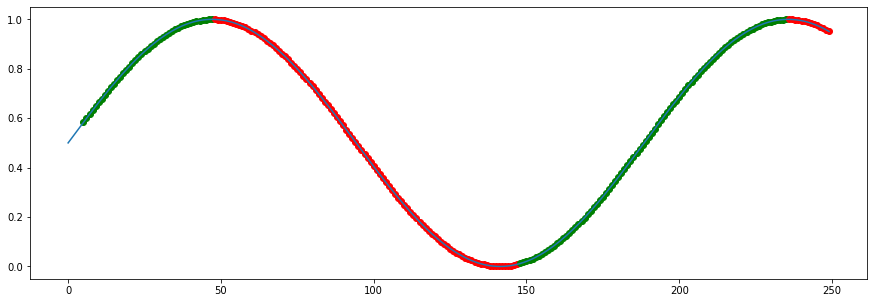

In [15]:
plt.figure(figsize = (15, 5))
plt.plot(environment.data)
for e, a in enumerate(actions):
    e += WINDOW_SHAPE
    if a == 1:
        plt.scatter(e, environment.data.iloc[e], color = 'green')
    elif a == -1:
        plt.scatter(e, environment.data.iloc[e], color = 'red')
    else:
        pass
plt.show()

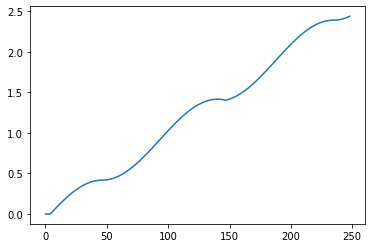

In [16]:
backtest = pd.DataFrame({
    'price': environment.data.values.flatten(),
    'signal': [0] * WINDOW_SHAPE + actions
})
backtest['price_diff'] = backtest['price'].diff().shift(-1)
(backtest['price_diff'] * backtest['signal']).cumsum().plot()

In [17]:
# Noisy Data
environment2 = Environment(DATASET_LENGTH, True, True)
actions = []
for j in range(WINDOW_SHAPE, DATASET_LENGTH, REWARD_TIME): 
    state_j = environment2.get_state(j, WINDOW_SHAPE)
    q_value_j = agent.get_value_action_value(state_j)
    actions.append(action_to_backtest_action[np.argmax(q_value_j)])

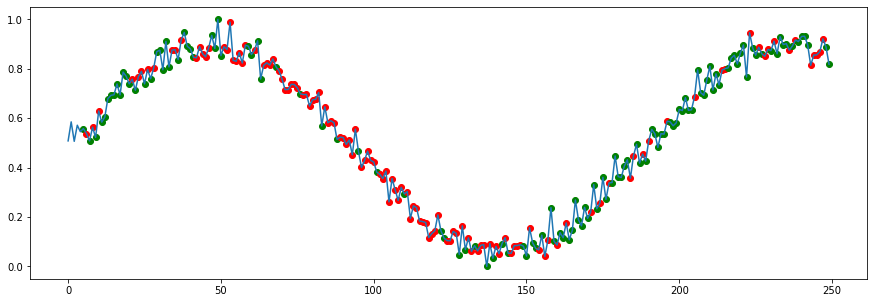

In [18]:
plt.figure(figsize = (15, 5))
plt.plot(environment2.data)
for e, a in enumerate(actions):
    e += WINDOW_SHAPE
    if a == 1:
        plt.scatter(e, environment2.data.iloc[e], color = 'green')
    elif a == -1:
        plt.scatter(e, environment2.data.iloc[e], color = 'red')
    else:
        pass
plt.show()

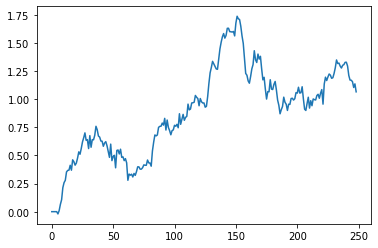

In [19]:
backtest = pd.DataFrame({
    'price': environment2.data.values.flatten(),
    'signal': [0] * WINDOW_SHAPE + actions
})
backtest['price_diff'] = backtest['price'].diff().shift(-1)
(backtest['price_diff'] * backtest['signal']).cumsum().plot()

In [20]:
# Other function
data_new = pd.DataFrame(
    np.cos(np.arange(DATASET_LENGTH)/5.0) + 
    np.cos(np.arange(DATASET_LENGTH)/10) + 
    np.cos(np.arange(DATASET_LENGTH)/20) + 
    np.cos(np.arange(DATASET_LENGTH)/30)
    )

In [21]:
print(data_new.head())
data_new.shape

          0
0  4.000000
1  3.973265
2  3.893910
3  3.764447
4  3.588959


(250, 1)

In [22]:
environment3 = Environment(DATASET_LENGTH, True, True, data_new)
actions = []
for j in range(WINDOW_SHAPE, DATASET_LENGTH, REWARD_TIME): 
    state_j = environment3.get_state(j, WINDOW_SHAPE)
    q_value_j = agent.get_value_action_value(state_j)
    actions.append(action_to_backtest_action[np.argmax(q_value_j)])

In [23]:
print(environment3.data)

            0
0    1.000000
1    0.983468
2    0.969219
3    0.945140
4    0.910527
..        ...
245  0.649684
246  0.676772
247  0.755673
248  0.744514
249  0.754508

[250 rows x 1 columns]


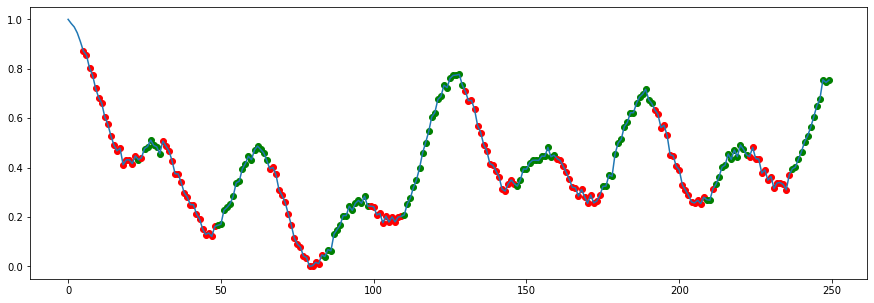

In [24]:
plt.figure(figsize = (15, 5))
plt.plot(environment3.data)
for e, a in enumerate(actions):
    e += WINDOW_SHAPE
    if a == 1:
        plt.scatter(e, environment3.data.iloc[e], color = 'green')
    elif a == -1:
        plt.scatter(e, environment3.data.iloc[e], color = 'red')
    else:
        pass
plt.show()

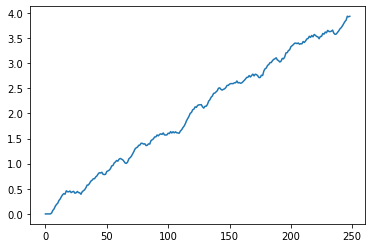

In [25]:
backtest = pd.DataFrame({
    'price': environment3.data.values.flatten(),
    'signal': [0] * WINDOW_SHAPE + actions
})
backtest['price_diff'] = backtest['price'].diff().shift(-1)
(backtest['price_diff'] * backtest['signal']).cumsum().plot()

In [26]:
# Tick data
from google.colab import files
files.upload()
# choose the file on your computer to upload it then import data # DAT_ASCII_GBPUSD_T_201701.csv

Saving DAT_ASCII_GBPUSD_T_201701.csv to DAT_ASCII_GBPUSD_T_201701.csv


In [27]:
!ls

DAT_ASCII_GBPUSD_T_201701.csv  sample_data


In [33]:
# Load Data
tick_data = pd.read_csv('DAT_ASCII_GBPUSD_T_201701.csv')
#drop excess columns from DataFrame
tick_data.drop(tick_data.columns[0], axis=1, inplace=True)
tick_data.drop(tick_data.columns[1], axis=1, inplace=True)
tick_data.drop(tick_data.columns[1], axis=1, inplace=True)
# drop first row
tick_data.drop(index=tick_data.index[0], axis=0, inplace=True)
tick_data = tick_data.head(250) # limit to 250 ticks for example
print(tick_data.head())
print(tick_data.shape)

   1.234000
1   1.23401
2   1.23399
3   1.23404
4   1.23403
5   1.23407
(250, 1)


In [35]:
# Run Agent on Tick Data , No added noise,
environment4 = Environment(DATASET_LENGTH, True, False, tick_data)
actions = []
for j in range(WINDOW_SHAPE, DATASET_LENGTH, REWARD_TIME): 
    state_j = environment4.get_state(j, WINDOW_SHAPE)
    q_value_j = agent.get_value_action_value(state_j)
    actions.append(action_to_backtest_action[np.argmax(q_value_j)])

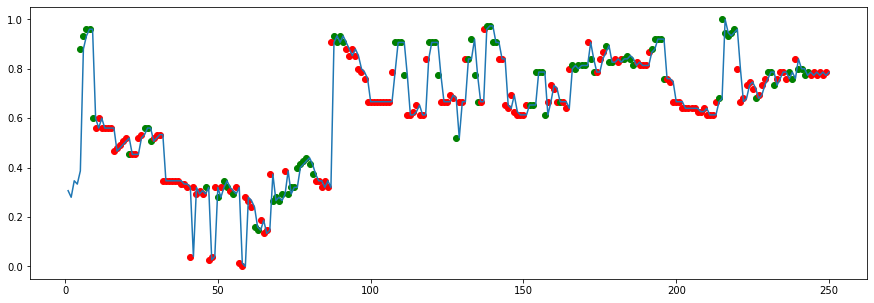

In [36]:
plt.figure(figsize = (15, 5))
plt.plot(environment4.data)
for e, a in enumerate(actions):
    e += WINDOW_SHAPE
    if a == 1:
        plt.scatter(e, environment4.data.iloc[e], color = 'green')
    elif a == -1:
        plt.scatter(e, environment4.data.iloc[e], color = 'red')
    else:
        pass
plt.show()